In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["THEANO_FLAGS"] = "floatX=float64"

In [3]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pymc3 as pm
import theano
import theano.tensor as tt

# this notebook show DEBUG log messages
logging.getLogger('pymc3').setLevel(logging.DEBUG)

import arviz
import IPython.display

# pymc3.ode: Shapes and benchmarking

### Demo Scenario: Simple enzymatic reaction
The model has two ODEs with 3 parameters in total.

In our generated data, we'll observe `S` and `P` at different times to demonstrate how to slice in such cases.

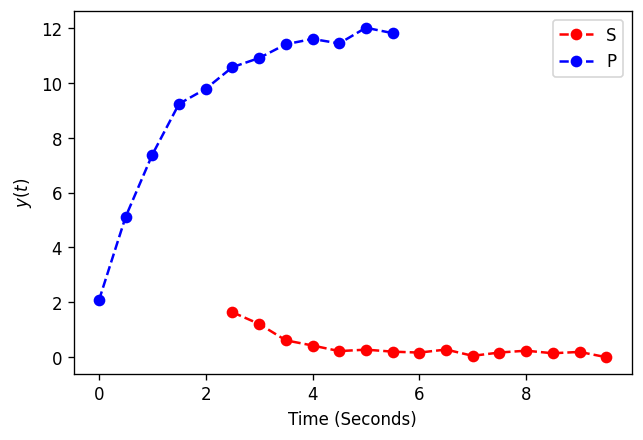

In [4]:
# For reproducibility
np.random.seed(23489)

class Chem:
    @staticmethod
    def reaction(y, t, p):
        S, P = y[0], y[1]
        vmax, K_S = p[0], p[1]
        dPdt = vmax * (S / K_S + S)
        dSdt = -dPdt
        return [
            dSdt,
            dPdt,
        ]

# Times for observation
times = np.arange(0,10,0.5)
red = np.arange(5, len(times))
blue = np.arange(12)
x_obs_1 = times[red]
x_obs_2 = times[blue]

y0_true = (10, 2)
theta_true = vmax, K_S = (0.5, 2)
sigma = 0.2

y_obs = odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
y_obs_1 = np.random.normal(y_obs[red,0], sigma)
y_obs_2 = np.random.normal(y_obs[blue,1], sigma)

fig, ax = plt.subplots(dpi=120)
plt.plot(x_obs_1, y_obs_1, label='S', linestyle='dashed', marker='o', color='red')
plt.plot(x_obs_2, y_obs_2, label='P', linestyle='dashed', marker='o', color='blue')
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$')
plt.show()

In [5]:
# To demonstrate that test-value computation works, but also for debugging
theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity = 'high'
theano.config.traceback.limit = 100

In [6]:
def get_model():
    with pm.Model() as pmodel:    
        sigma = pm.HalfCauchy('sigma', 1)
        vmax = pm.Lognormal('vmax', 0, 1)
        K_S = pm.Lognormal('K_S', 0, 1)
        s0 = pm.Normal('red_0', mu=10, sd=2)

        y_hat = pm.ode.DifferentialEquation(
            func=Chem.reaction,
            times=times,
            n_states=len(y0_true), n_theta=len(theta_true)
        )(
            y0=[s0, y0_true[1]],
            theta=[vmax, K_S],
            return_sens=False
        )

        red_hat = y_hat.T[0][red]
        blue_hat = y_hat.T[1][blue]

        Y_red = pm.Normal('Y_red', mu=red_hat, sd=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sd=sigma, observed=y_obs_2)

    return pmodel

def make_benchmark():
    pmodel = get_model()
    
    # select input variables & test values
    t_inputs = pmodel.cont_vars
    # apply transformations as required
    test_inputs = (np.log(0.2), np.log(0.5), np.log(1.9), 10)
    
    # create a test function for evaluating the logp value
    print('Compiling f_logpt')
    f_logpt = theano.function(
        inputs=t_inputs,
        outputs=[pmodel.logpt],
        # with float32, allow downcast because the forward integration is always float64
        allow_input_downcast=(theano.config.floatX == 'float32')
    )
    print(f'Test logpt:')
    print(f_logpt(*test_inputs))
    
    # and another test function for evaluating the gradient
    print('Compiling f_logpt')
    f_grad = theano.function(
        inputs=t_inputs,
        outputs=tt.grad(pmodel.logpt, t_inputs),
        # with float32, allow downcast because the forward integration is always float64
        allow_input_downcast=(theano.config.floatX == 'float32')
    )
    print(f'Test gradient:')
    print(f_grad(*test_inputs))
    
    # make a benchmarking function that uses random inputs
    # - to avoid cheating by caching
    # - to get a more realistic distribution over simulation times
    def bm():
        f_grad(
            np.log(np.random.uniform(0.1, 0.2)),
            np.log(np.random.uniform(0.4, 0.6)),
            np.log(np.random.uniform(1.9, 2.1)),
            np.random.uniform(9, 11)
        )
    return pmodel, bm

In [7]:
model, benchmark = make_benchmark()

print('\nPerformance:')
%timeit benchmark()

Applied log-transform to sigma and added transformed sigma_log__ to model.
Applied log-transform to vmax and added transformed vmax_log__ to model.
Applied log-transform to K_S and added transformed K_S_log__ to model.
make_node for inputs -5657601466326543627


Compiling f_logpt
Test logpt:
[array(5.73420592)]
Compiling f_logpt


grad w.r.t. inputs -5657601466326543627


Test gradient:
[array(-12.25120609), array(26.04782273), array(-9.38484546), array(11.26454126)]

Performance:
23.7 ms ± 429 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Inspecting the computation graphs
If you zoom in to the large `DifferentialEquation` ellipse in the top, you can follow the blue arrows downwards to see that the gradient is directly passed from the original DifferentialEquation Op node.

In [8]:
theano.printing.pydotprint(tt.grad(model.logpt, model.vmax), 'ODE_API_shapes_and_benchmarking.png')
IPython.display.Image('ODE_API_shapes_and_benchmarking.png')

grad w.r.t. inputs -5657601466326543627


The output file is available at ODE_API_shapes_and_benchmarking.png


With the cell below, you can visualize the computation graph interactively. (The HTML file is saved next to this notebook.)

If you need to install `graphviz/pydot`, you can use these commands:
```
conda install -c conda-forge python-graphviz
pip install pydot
```

In [9]:
from theano import d3viz
d3viz.d3viz(model.logpt, 'ODE_API_shapes_and_benchmarking.html')

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy   1.18.5
pymc3   3.9.0
theano  1.0.4
logging 0.5.1.2
IPython 7.15.0
arviz   0.8.3
last updated: Sat Jun 13 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
